In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('boxoffice.csv',encoding='latin-1')
df.head()


,title,domestic_revenue,world_revenue,distributor,opening_revenue,opening_theaters,budget,MPAA,genres,release_days
0,Star Wars: Episode VIII - The Last Jedi,"$620,181,382","$1,332,539,889",Walt Disney Studios Motion Pictures,"$220,009,584","4,232","$317,000,000",PG-13,"Action,Adventure,Fantasy,Sci-Fi",382
1,The Fate of the Furious,"$226,008,385","$1,236,005,118",Universal Pictures,"$98,786,705","4,310","$250,000,000",PG-13,"Action,Adventure,Thriller",262
2,Wonder Woman,"$412,563,408","$821,847,012",Warner Bros.,"$103,251,471","4,165","$149,000,000",PG-13,"Action,Adventure,Fantasy,Sci-Fi,War",217
3,Guardians of the Galaxy Vol. 2,"$389,813,101","$863,756,051",Walt Disney Studios Motion Pictures,"$146,510,104","4,347","$200,000,000",PG-13,"Action,Adventure,Comedy,Sci-Fi",241
4,Beauty and the Beast,"$504,014,165","$1,263,521,126",Walt Disney Studios Motion Pictures,"$174,750,616","4,210","$160,000,000",PG,"Family,Fantasy,Musical,Romance",290


In [ ]:
df.shape


(2694, 10)

In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2694 entries, 0 to 2693
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   title             2694 non-null   object
 1   domestic_revenue  2694 non-null   object
 2   world_revenue     2694 non-null   object
 3   distributor       2694 non-null   object
 4   opening_revenue   2390 non-null   object
 5   opening_theaters  2383 non-null   object
 6   budget            397 non-null    object
 7   MPAA              1225 non-null   object
 8   genres            2655 non-null   object
 9   release_days      2694 non-null   object
dtypes: object(10)
memory usage: 210.6+ KB


In [ ]:
df.describe().T


,count,unique,top,freq
title,2694,2468,A Beautiful Planet,3
domestic_revenue,2694,2495,"$11,272,008",3
world_revenue,2694,2501,"$25,681,505",3
distributor,2694,248,Fathom Events,292
opening_revenue,2390,2176,"$4,696",3
opening_theaters,2383,732,1,503
budget,397,124,"$40,000,000",14
MPAA,1225,8,R,568
genres,2655,567,Documentary,351
release_days,2694,457,347,35


In [ ]:
# We will be predicting only
# domestic_revenue in this article.

to_remove = ['world_revenue', 'opening_revenue']
df.drop(to_remove, axis=1, inplace=True)


In [ ]:
df.isnull().sum() * 100 / df.shape[0]


title                0.000000
domestic_revenue     0.000000
distributor          0.000000
opening_theaters    11.544172
budget              85.263549
MPAA                54.528582
genres               1.447661
release_days         0.000000
dtype: float64

In [ ]:
# Handling the null value columns
df.drop('budget', axis=1, inplace=True)

for col in ['MPAA', 'genres']:
	df[col] = df[col].fillna(df[col].mode()[0])

df.dropna(inplace=True)

df.isnull().sum().sum()


0

In [ ]:
df['domestic_revenue'] = df['domestic_revenue'].str[1:]

for col in ['domestic_revenue', 'opening_theaters', 'release_days']:
	df[col] = df[col].str.replace(',', '')

	# Selecting rows with no null values
	# in the columns on which we are iterating.
	temp = (~df[col].isnull())
	df[temp][col] = df[temp][col].convert_dtypes(float)

	df[col] = pd.to_numeric(df[col], errors='coerce')


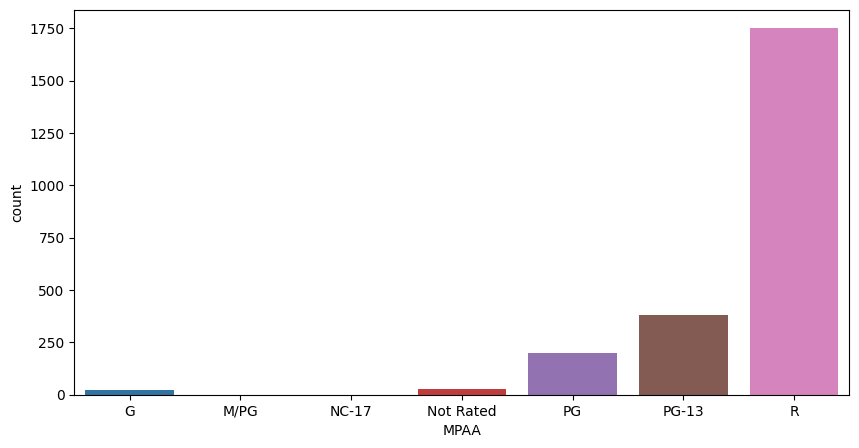

In [ ]:
#count plot for MPAA that shows the count of observations in each category of a categorical variable

import matplotlib.pyplot as plt
import seaborn as sb

# Assuming 'MPAA' column is categorical or needs to be converted to categorical
df['MPAA'] = df['MPAA'].astype('category')

plt.figure(figsize=(10, 5))
sb.countplot(data=df, x='MPAA')  # Specify 'data' and 'x' parameters
plt.show()



In [ ]:
df.groupby('MPAA').mean()['domestic_revenue']


MPAA
G            3.539276e+07
M/PG         5.113500e+05
NC-17        1.368800e+04
Not Rated    4.897703e+05
PG           5.379622e+07
PG-13        5.891966e+07
R            6.591336e+06
Name: domestic_revenue, dtype: float64

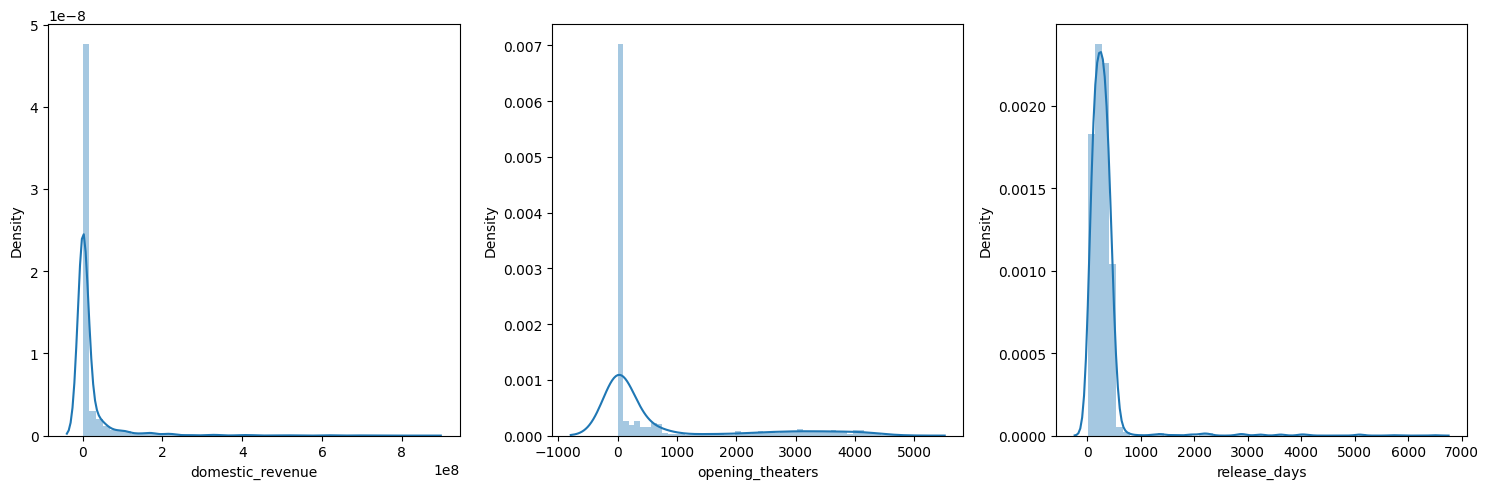

In [ ]:
#Three subplots show the distribution of 'domestic_revenue,' 'opening_theaters,' and 'release_days.'
#The plots help understand the spread and central tendency of these features.

plt.subplots(figsize=(15, 5))

features = ['domestic_revenue', 'opening_theaters', 'release_days']
for i, col in enumerate(features):
	plt.subplot(1, 3, i+1)
	sb.distplot(df[col])
plt.tight_layout()
plt.show()


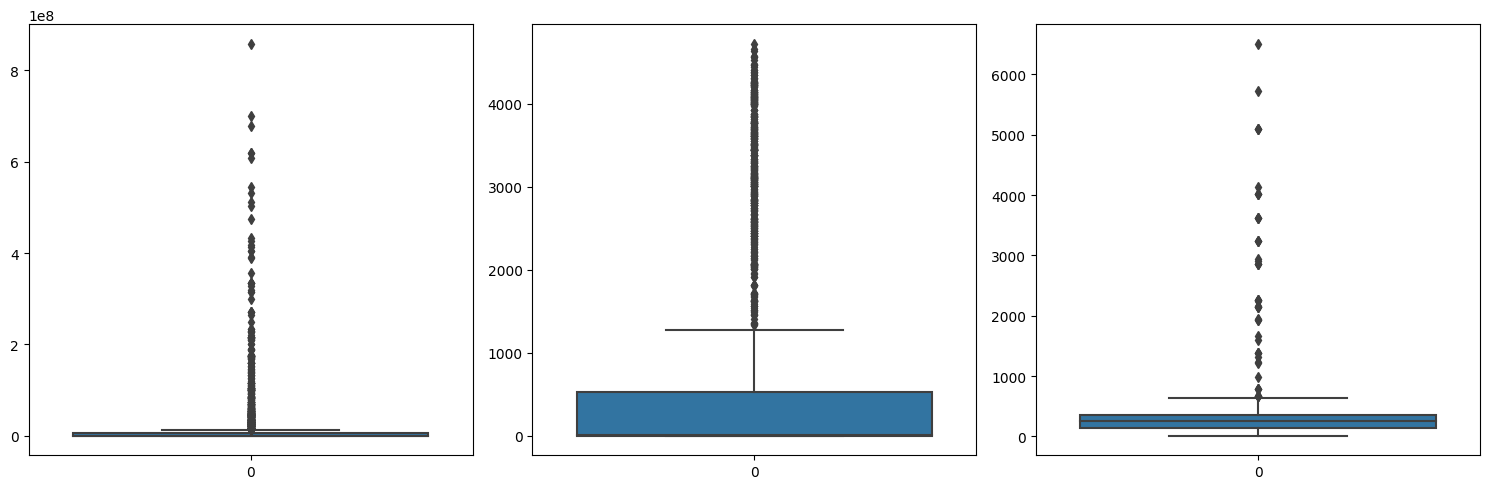

In [ ]:
#Three subplots display box plots for 'domestic_revenue,' 'opening_theaters,' and 'release_days.'
#Outliers and the interquartile range (IQR) can be observed.

plt.subplots(figsize=(15, 5))

for i, col in enumerate(features):
	plt.subplot(1, 3, i+1)
	sb.boxplot(df[col])
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

# Assuming 'features' is a list of column names
for col in features:
    df[col] = df[col].apply(lambda x: np.log10(x))



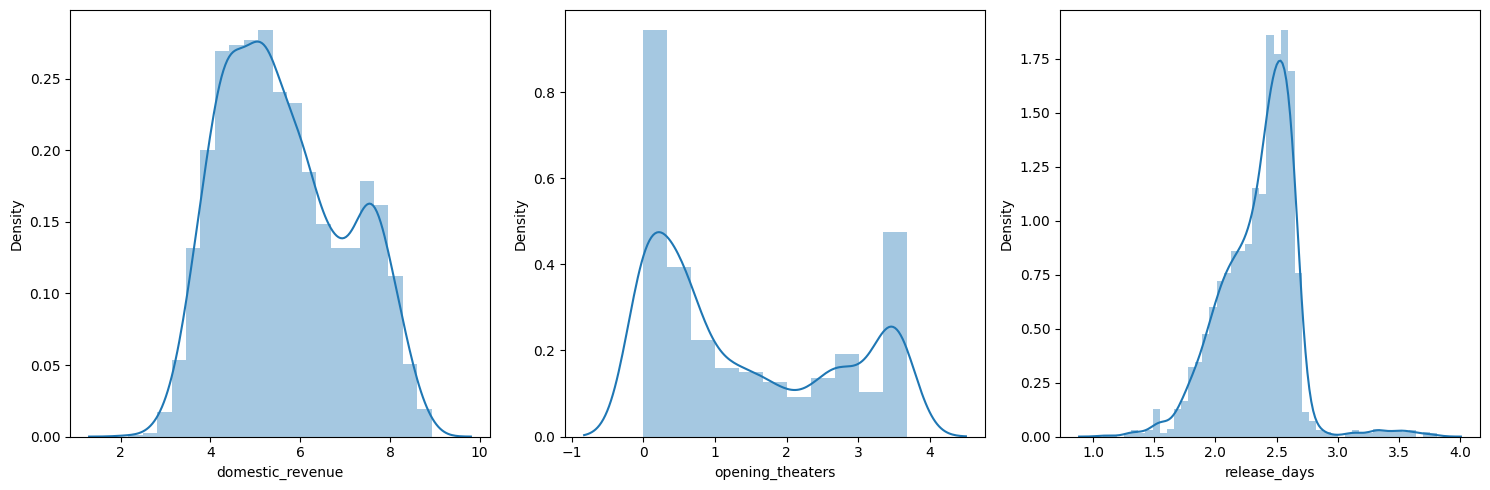

In [ ]:
#The distribution plots show the effect of log transformation on 'domestic_revenue,' 'opening_theaters,' and 'release_days.'
#Log transformation is applied to handle right-skewed distributions.


plt.subplots(figsize=(15, 5))
for i, col in enumerate(features):
	plt.subplot(1, 3, i+1)
	sb.distplot(df[col])
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(df['genres'])
features = vectorizer.transform(df['genres']).toarray()

genres = vectorizer.get_feature_names_out()  # Use get_feature_names_out() instead of get_feature_names()
for i, name in enumerate(genres):
    df[name] = features[:, i]

df.drop('genres', axis=1, inplace=True)


In [ ]:
removed = 0
for col in df.loc[:, 'action':'western'].columns:

	# Removing columns having more
	# than 95% of the values as zero.
	if (df[col] == 0).mean() > 0.95:
		removed += 1
		df.drop(col, axis=1, inplace=True)

print(removed)
print(df.shape)


11
(2383, 24)


In [ ]:
for col in ['distributor', 'MPAA']:
	le = LabelEncoder()
	df[col] = le.fit_transform(df[col])


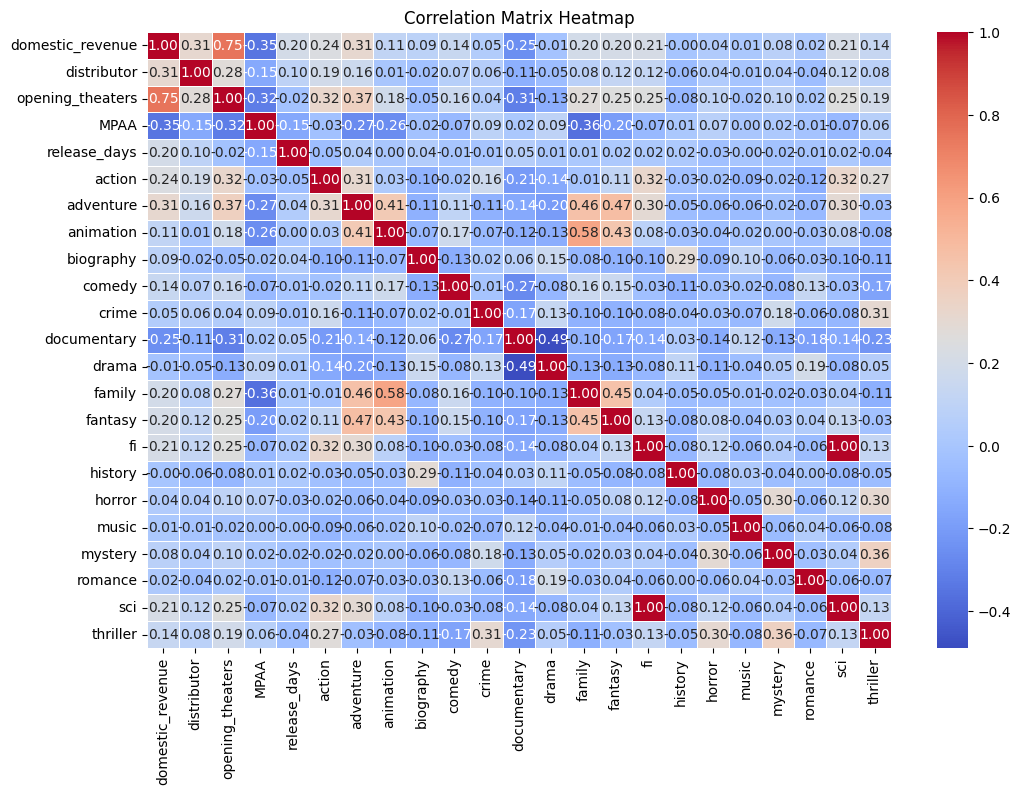

In [ ]:
import seaborn as sb
import matplotlib.pyplot as plt

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sb.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix Heatmap")
plt.show()


In [ ]:
features = df.drop(['title', 'domestic_revenue', 'fi'], axis=1)
target = df['domestic_revenue'].values

X_train, X_val,\
	Y_train, Y_val = train_test_split(features, target,
									test_size=0.1,
									random_state=22)
X_train.shape, X_val.shape


((2144, 21), (239, 21))

In [ ]:
# Normalizing the features for stable and fast training.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)


Training MAE:  0.1311083568380254
Training MSE:  0.03806963424800606
Training RMSE:  0.19511441322466688
--------------
Validation MAE:  0.4340367343796249
Validation MSE:  0.3524018681116089
Validation RMSE:  0.5936344566411293


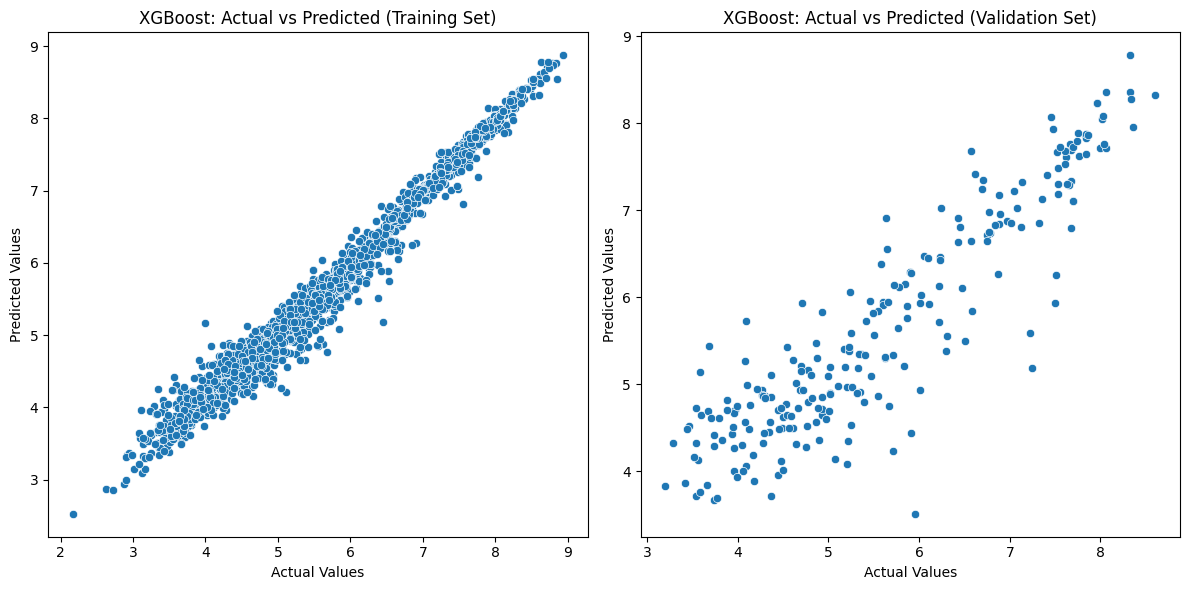

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np

# Define and train your XGBoost model
model = XGBRegressor()
model.fit(X_train, Y_train)

# Make predictions on the training set
train_preds = model.predict(X_train)

# Calculate training metrics
train_mae = mean_absolute_error(Y_train, train_preds)
train_mse = mean_squared_error(Y_train, train_preds)
train_rmse = np.sqrt(train_mse)

# Print training metrics
print('Training MAE: ', train_mae)
print('Training MSE: ', train_mse)
print('Training RMSE: ', train_rmse)

# Make predictions on the validation set
val_preds = model.predict(X_val)

# Calculate validation metrics
val_mae = mean_absolute_error(Y_val, val_preds)
val_mse = mean_squared_error(Y_val, val_preds)
val_rmse = np.sqrt(val_mse)

print('--------------')
# Print validation metrics
print('Validation MAE: ', val_mae)
print('Validation MSE: ', val_mse)
print('Validation RMSE: ', val_rmse)

# Plotting the actual vs predicted values for XGBoost on the training set
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sb.scatterplot(x=Y_train, y=train_preds)
plt.title('XGBoost: Actual vs Predicted (Training Set)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# Plotting the actual vs predicted values for XGBoost on the validation set
plt.subplot(1, 2, 2)
sb.scatterplot(x=Y_val, y=val_preds)
plt.title('XGBoost: Actual vs Predicted (Validation Set)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

plt.tight_layout()
plt.show()


Training MAE:  0.6346133108283997
Training MSE:  0.6532060615846579
Training RMSE:  0.8082116440541165
----------
Validation MAE:  0.6561183171407359
Validation MSE:  0.6996843779208017
Validation RMSE:  0.8364713849981968


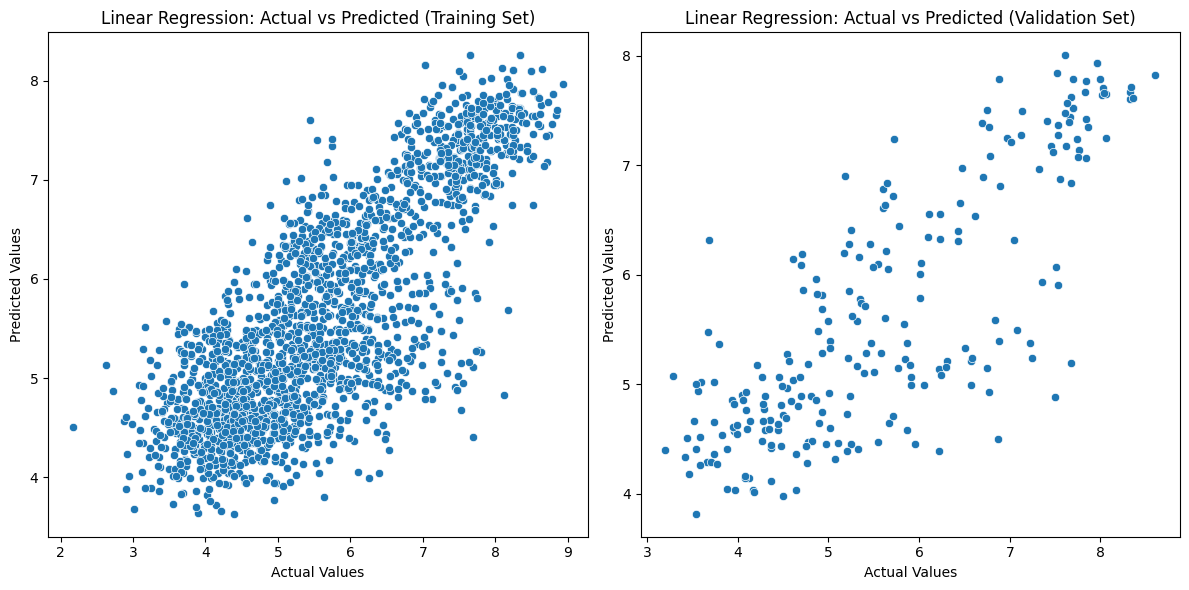

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np

# Assuming you have X_train, X_val, Y_train, Y_val defined

# Define and train your Linear Regression model
model = LinearRegression()
model.fit(X_train, Y_train)

# Make predictions on the training set
train_preds = model.predict(X_train)

# Calculate training metrics
train_mae = mean_absolute_error(Y_train, train_preds)
train_mse = mean_squared_error(Y_train, train_preds)
train_rmse = np.sqrt(train_mse)

# Print training metrics
print('Training MAE: ', train_mae)
print('Training MSE: ', train_mse)
print('Training RMSE: ', train_rmse)

# Make predictions on the validation set
val_preds = model.predict(X_val)

print('----------')

# Calculate validation metrics
val_mae = mean_absolute_error(Y_val, val_preds)
val_mse = mean_squared_error(Y_val, val_preds)
val_rmse = np.sqrt(val_mse)

# Print validation metrics
print('Validation MAE: ', val_mae)
print('Validation MSE: ', val_mse)
print('Validation RMSE: ', val_rmse)

# Plotting the actual vs predicted values for Linear Regression on the training set
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sb.scatterplot(x=Y_train, y=train_preds)
plt.title('Linear Regression: Actual vs Predicted (Training Set)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# Plotting the actual vs predicted values for Linear Regression on the validation set
plt.subplot(1, 2, 2)
sb.scatterplot(x=Y_val, y=val_preds)
plt.title('Linear Regression: Actual vs Predicted (Validation Set)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

plt.tight_layout()
plt.show()


Training MAE (SVR):  0.4838016293845128
Training MSE (SVR):  0.465866368865944
Training RMSE (SVR):  0.6825440417042288
---------
Validation MAE (SVR):  0.6168029738889681
Validation MSE (SVR):  0.6796360371422265
Validation RMSE (SVR):  0.824400410687808


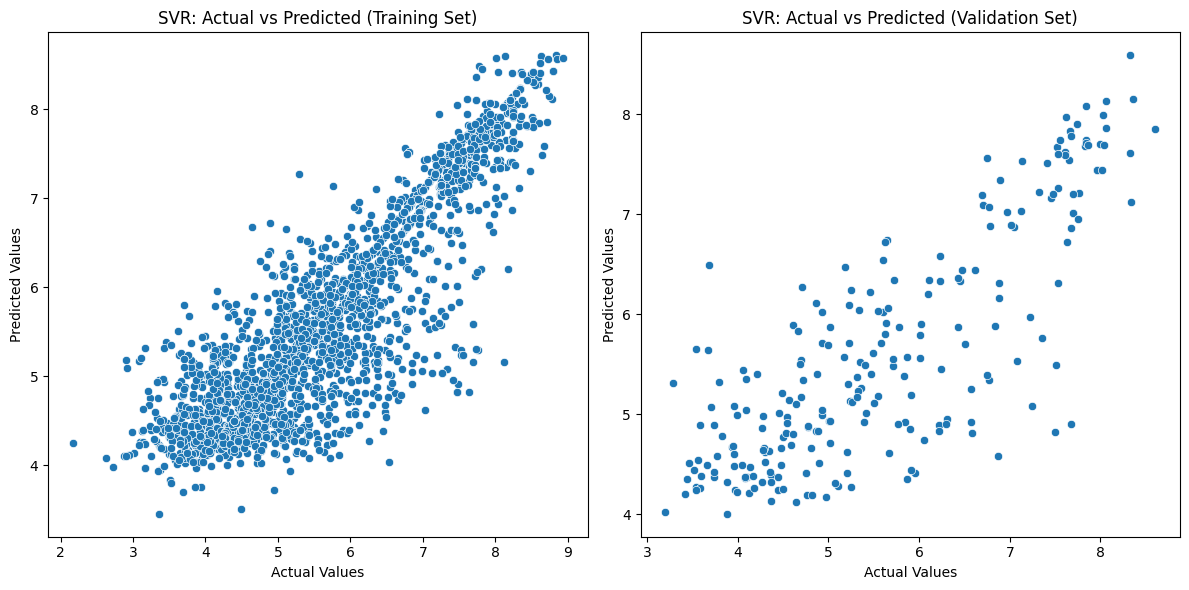

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np

# Instantiate the SVR model
svr_model = SVR()

# Fit the model to the training data
svr_model.fit(X_train, Y_train)

# Make predictions on the training set
train_preds_svr = svr_model.predict(X_train)

# Calculate training metrics
train_mae_svr = mean_absolute_error(Y_train, train_preds_svr)
train_mse_svr = mean_squared_error(Y_train, train_preds_svr)
train_rmse_svr = np.sqrt(train_mse_svr)

# Print training metrics
print('Training MAE (SVR): ', train_mae_svr)
print('Training MSE (SVR): ', train_mse_svr)
print('Training RMSE (SVR): ', train_rmse_svr)

# Plot actual vs predicted values for the training set
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sb.scatterplot(x=Y_train, y=train_preds_svr)
plt.title('SVR: Actual vs Predicted (Training Set)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# Make predictions on the validation set
val_preds_svr = svr_model.predict(X_val)

print('---------')

# Calculate validation metrics
val_mae_svr = mean_absolute_error(Y_val, val_preds_svr)
val_mse_svr = mean_squared_error(Y_val, val_preds_svr)
val_rmse_svr = np.sqrt(val_mse_svr)

# Print validation metrics
print('Validation MAE (SVR): ', val_mae_svr)
print('Validation MSE (SVR): ', val_mse_svr)
print('Validation RMSE (SVR): ', val_rmse_svr)

# Plot actual vs predicted values for the validation set
plt.subplot(1, 2, 2)
sb.scatterplot(x=Y_val, y=val_preds_svr)
plt.title('SVR: Actual vs Predicted (Validation Set)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# Display the plots
plt.tight_layout()
plt.show()


Training MAE (Random Forest):  0.15990931384937995
Training MSE (Random Forest):  0.05047131463665959
Training RMSE (Random Forest):  0.22465821738066824
--------
Validation MAE (Random Forest):  0.45072446143847467
Validation MSE (Random Forest):  0.3862920985432429
Validation RMSE (Random Forest):  0.6215240128452343


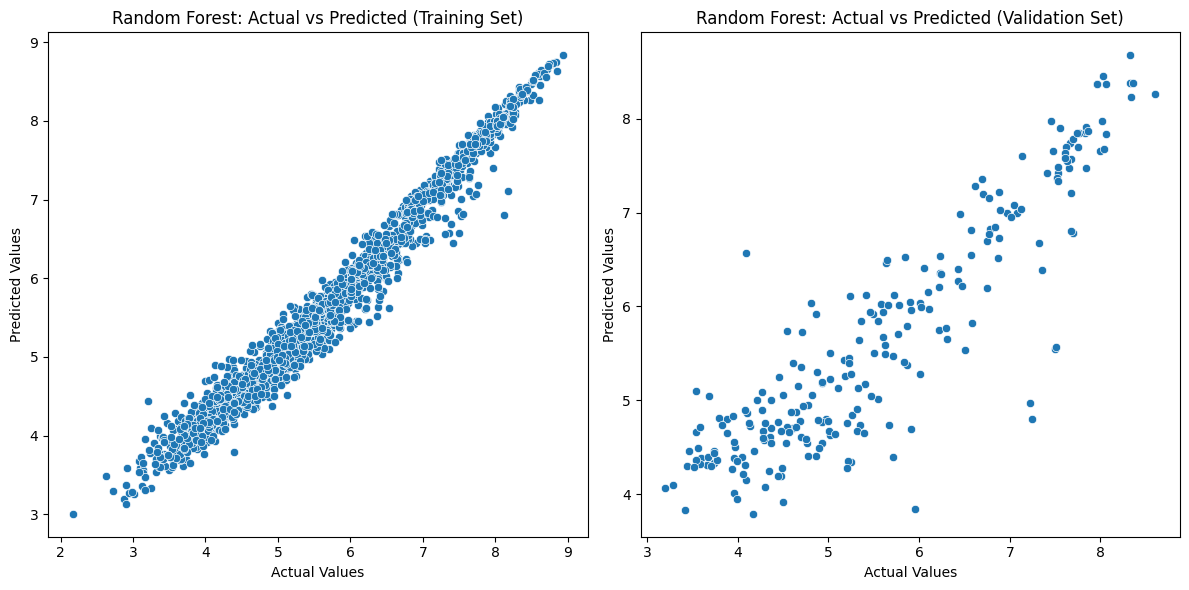

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np

# Instantiate the Random Forest regression model
rf_model = RandomForestRegressor(n_estimators=100, random_state=22)

# Fit the model to the training data
rf_model.fit(X_train, Y_train)

# Make predictions on the training set
train_preds_rf = rf_model.predict(X_train)

# Calculate training metrics
train_mae_rf = mean_absolute_error(Y_train, train_preds_rf)
train_mse_rf = mean_squared_error(Y_train, train_preds_rf)
train_rmse_rf = np.sqrt(train_mse_rf)

# Print training metrics
print('Training MAE (Random Forest): ', train_mae_rf)
print('Training MSE (Random Forest): ', train_mse_rf)
print('Training RMSE (Random Forest): ', train_rmse_rf)

# Plot actual vs predicted values for the training set
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sb.scatterplot(x=Y_train, y=train_preds_rf)
plt.title('Random Forest: Actual vs Predicted (Training Set)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# Make predictions on the validation set
val_preds_rf = rf_model.predict(X_val)

# Calculate validation metrics
val_mae_rf = mean_absolute_error(Y_val, val_preds_rf)
val_mse_rf = mean_squared_error(Y_val, val_preds_rf)
val_rmse_rf = np.sqrt(val_mse_rf)

print('--------')
# Print validation metrics
print('Validation MAE (Random Forest): ', val_mae_rf)
print('Validation MSE (Random Forest): ', val_mse_rf)
print('Validation RMSE (Random Forest): ', val_rmse_rf)

# Plot actual vs predicted values for the validation set
plt.subplot(1, 2, 2)
sb.scatterplot(x=Y_val, y=val_preds_rf)
plt.title('Random Forest: Actual vs Predicted (Validation Set)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# Display the plots
plt.tight_layout()
plt.show()
